In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!git clone https://github.com/khongtrunght/tranferBiggan.git 

In [3]:
cd pytorch-small-dataset-image-generation/

/content/pytorch-small-dataset-image-generation


Training

In [ ]:
!python train.py --dataset animal --gpu 0 --pretrained ./data/G_ema.pth  --iters 50000

Testing

In [17]:
data_size = 45
import glob
import os
import matplotlib
from PIL import Image
import numpy as np
import json

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torchvision
from models.setup_model import setup_model
from dataloaders.setup_dataloader_smallgan import setup_dataloader


from scipy.stats import truncnorm


def reconstruct(model, out_path, indices_labels, add_small_noise=False):
    with torch.no_grad():
        model.eval()
        device = next(model.parameters()).device
        dataset_size = model.embeddings.weight.size()[0]
        indices, labels = indices_labels
        if type(indices) != torch.Tensor:
            indices = torch.tensor(indices, device=device)
            labels = torch.tensor(labels, device=device)
        assert type(indices) == torch.Tensor
        indices = indices.to(device)
        embeddings = model.embeddings(indices)
        batch_size = embeddings.size()[0]

        # labels = [0, ] * batch_size
        # labels = torch.tensor(labels, device=device)
        labels = labels.to(device)
        labels_embeddings = model.linear(labels)

        if add_small_noise:
            embeddings += torch.randn(embeddings.size(), device=device)*0.01
        image_tensors = model(embeddings, labels_embeddings)
        return image_tensors

# see https://github.com/nogu-atsu/SmallGAN/blob/2293700dce1e2cd97e25148543532814659516bd/gen_models/ada_generator.py#L37-L53


def interpolate(model, out_path, source, dist, trncate=0.4, num=5):
    with torch.no_grad():
        model.eval()
        device = next(model.parameters()).device
        dataset_size = model.embeddings.weight.size()[0]
        indices = torch.tensor([source, dist], device=device)
        indices = indices.to(device)
        embeddings = model.embeddings(indices)
        embeddings = embeddings[[0]] * torch.linspace(1, 0, num, device=device)[
            :, None] + embeddings[[1]] * torch.linspace(0, 1, num, device=device)[:, None]

        batch_size = embeddings.size()[0]

        labels = [0, ] * batch_size
        labels = torch.tensor(labels, device=device)
        labels_embeddings = model.linear(labels)

        image_tensors = model(embeddings, labels_embeddings)
        return image_tensors

# from https://github.com/nogu-atsu/SmallGAN/blob/2293700dce1e2cd97e25148543532814659516bd/gen_models/ada_generator.py#L37-L53


def random(model, out_path, tmp=0.4, n=9, truncate=True):
    with torch.no_grad():
        model.eval()
        device = next(model.parameters()).device
        dataset_size = model.embeddings.weight.size()[0]
        dim_z = model.embeddings.weight.size(1)
        if truncate:
            embeddings = truncnorm(-tmp, tmp).rvs(n *
                                                  dim_z).astype("float32").reshape(n, dim_z)
        else:
            embeddings = np.random.normal(
                0, tmp, size=(n, dim_z)).astype("float32")
        embeddings = torch.tensor(embeddings, device=device)
        batch_size = embeddings.size()[0]

        labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]
        labels = torch.tensor(labels, device=device)
        label_embeddings = model.linear(labels)

        image_tensors = model(embeddings, label_embeddings)
        return image_tensors


In [11]:
dataloader = setup_dataloader("anime",batch_size=2)
dataset_size = len(dataloader.dataset)
exp_dir = "./experiments/train_dataset-animal_model-biggan128-ada_2021-12-29-12-06-40/"
print(json.load(open(exp_dir+"args.json")))
model = setup_model("biggan128-ada",dataset_size=data_size,resume=exp_dir+"checkpoint_iter14000.pth.tar")
model = model.cuda()

{'batch': 25, 'dataset': 'animal', 'eval_freq': 500, 'githash': None, 'gpu': '0', 'iters': 50000, 'loss_dist_per': 'l2', 'loss_emd': 0.1, 'loss_norm_img': 1, 'loss_norm_per': 1, 'loss_per': 0.1, 'loss_re': 0.02, 'lr_bsa_l': 0.0005, 'lr_c_embed': 0.001, 'lr_embed': 0.05, 'lr_g_batch_stat': 0.0005, 'lr_g_l': 1e-07, 'model': 'biggan128-ada', 'pretrained': './data/G_ema.pth', 'print_freq': 100, 'resume': '/content/pytorch-small-dataset-image-generation/experiments/train_dataset-animal_model-biggan128-ada_2021-12-29-11-03-08/checkpoint_iter11500.pth.tar', 'savedir': 'train', 'saveroot': './experiments', 'step': 4000, 'step_facter': 0.3, 'workers': 4}
model name: biggan128-ada
Adding attention layer in G at resolution 64
resuming trained weights from ./experiments/train_dataset-animal_model-biggan128-ada_2021-12-29-12-06-40/checkpoint_iter14000.pth.tar


In [14]:
to_pil = torchvision.transforms.ToPILImage()
to_mul_pic_nor = lambda x : to_pil(torchvision.utils.make_grid(x, normalize=True)) 

In [34]:
test_cho = reconstruct(model, "test/reconstruct.png", [[15,16,17,18], [1,1,1,1]])
test_meo = reconstruct(model, "test/reconstruct.png", [[15,16,17,18], [0,0,0,0]])
test_wild = reconstruct(model, "test/reconstruct.png", [[39,40,41,42], [2,2,2,2]])

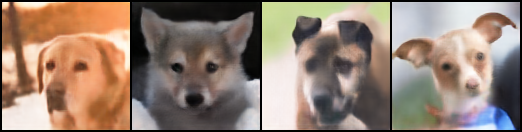

In [21]:
to_mul_pic_nor(test_cho)

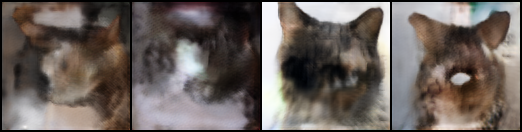

In [22]:
to_mul_pic_nor(test_meo)

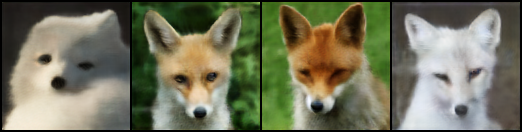

In [35]:
to_mul_pic_nor(test_wild)

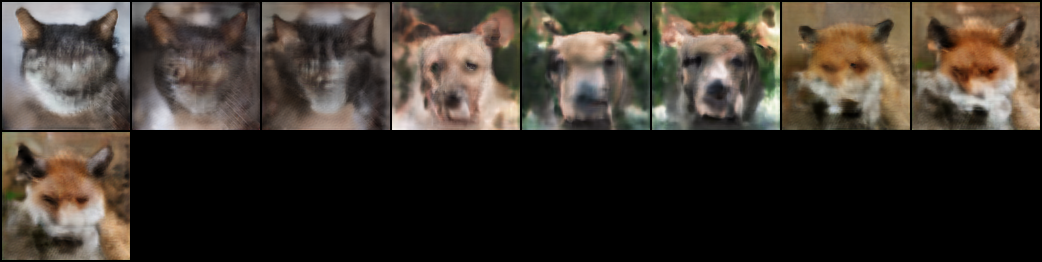

In [40]:
to_mul_pic_nor(random(model, "fasd", tmp=0.2, n=9, truncate=True))

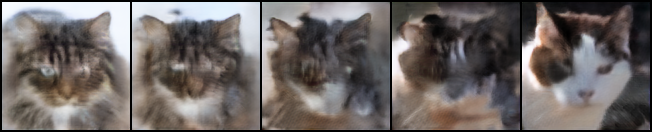

In [31]:
to_mul_pic_nor(interpolate(model, "abc", 2, 8, trncate=0.1, num=5))

In [ ]:
reconstruct(model,out_path="./samples/anime_reconstruct.jpg",indices= torch.arange(9))
interpolate(model,out_path="./samples/anime_interpolate.jpg",source=1,dist=2)
random(model,out_path="./samples/anime_random.jpg",tmp=0.2, n=9, truncate=True)

plt.figure(figsize=(10,10))
im = Image.open("./samples/anime_reconstruct.jpg")
plt.imshow(im)
plt.show()

plt.figure(figsize=(10,10))
im = Image.open("./samples/anime_interpolate.jpg")
plt.imshow(im)
plt.show()

plt.figure(figsize=(10,10))
im = Image.open("./samples/anime_random.jpg")
plt.imshow(im)
plt.show()

In [37]:
labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]
labels = torch.tensor(labels).cuda()
label_embeddings = model.linear(labels)

In [38]:
label_embeddings[0]

tensor([ 0.0037, -0.0724, -0.0206, -0.5452,  0.8071, -0.5196, -0.1859,  0.2761,
        -0.1324, -0.3063, -0.0661, -0.1656,  0.2285, -0.5637,  0.0097,  0.0167,
         0.1583,  0.0340, -0.0289, -0.1937,  0.2083,  0.2128,  0.2548,  0.1983,
         0.3748, -0.3648,  0.3631,  0.2164,  0.2642, -0.1009,  0.4418, -0.0138,
        -0.0755, -0.2185,  0.0643, -0.0838,  0.5630, -0.0220,  0.0507, -0.2236,
         0.4840,  0.2839, -0.1675,  0.0578,  0.4667, -0.1630, -0.1870,  0.6608,
         0.3283,  0.2785, -0.0239, -0.0271, -0.1597, -0.0309,  0.4503, -0.1706,
         0.4878, -0.4063, -0.1566,  0.0790,  0.2398,  0.2274, -0.4348, -0.2840,
         0.1694,  0.4704, -0.3457,  0.1931, -0.0436, -0.1235, -0.1568,  0.3172,
        -0.1795,  0.0019,  0.0656,  0.1477,  0.0704, -0.0420,  0.3023,  0.2998,
         0.4670, -0.5160, -0.5438, -0.0471, -0.2717, -0.0538, -0.2948, -0.4938,
         0.2552,  0.0641, -0.2588, -0.0601,  0.0800,  0.2972,  0.0499, -0.0676,
         0.1787,  0.0748,  0.0362, -0.28

In [39]:
label_embeddings[3]

tensor([ 0.0056,  0.3048, -0.4157,  0.0126,  0.1338, -0.0800,  0.2093, -0.0808,
         0.2649,  0.1712, -0.0349, -0.2357,  0.1872, -0.1343, -0.3200,  0.6095,
         0.1219,  0.0604,  0.1610, -0.4535, -0.2668, -0.0762,  0.0619, -0.2571,
         0.1687,  0.0531,  0.1353, -0.0565, -0.0533,  0.1422,  0.3068,  0.0456,
         0.4593, -0.2308, -0.4435, -0.3483, -0.0455, -0.0158, -0.1385,  0.3558,
         0.2577, -0.1820, -0.4366,  0.1125,  0.0213, -0.5246, -0.3627,  0.1237,
         0.2785,  0.1621,  0.0612,  0.0369, -0.5165,  0.1191,  0.3064, -0.1563,
         0.2227, -0.2059, -0.5390,  0.3958,  0.1561,  0.1707,  0.0959, -0.0992,
         0.2534,  0.3632, -0.2750,  0.2239, -0.2776, -0.0362, -0.3821, -0.0593,
         0.2822, -0.0379,  0.0596, -0.0535, -0.2140,  0.1436,  0.1874,  0.0650,
         0.7307, -0.3578,  0.1425, -0.0398, -0.1628,  0.2189,  0.6460, -0.3630,
        -0.0577,  0.2408, -0.5478,  0.1369, -0.0419,  0.0238,  0.4312,  0.8278,
        -0.3837,  0.0858,  0.4064,  0.06